In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

## Figure 1A

First, create the landscape and train various models on a 100 sequence dataset

In [3]:
problem = flexs.landscapes.rna.registry()['L14_RNA1']
wt = problem['starts'][2]
landscape = flexs.landscapes.RNABinding(**problem['params'])

train_x = np.array(list(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000)))
train_y = landscape.get_fitness(train_x)

cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(len(wt), alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])

models = {
    'alpha=1': baselines.models.NoisyAbstractModel(landscape, signal_strength=1),
    'alpha=0.9': baselines.models.NoisyAbstractModel(landscape, signal_strength=0.9),
    'alpha=0.75': baselines.models.NoisyAbstractModel(landscape, signal_strength=0.75),
    'alpha=0': baselines.models.NoisyAbstractModel(landscape, signal_strength=0),
    'CNN Ensemble': cnn_ensemble
}

for model in models.values():
    model.train(train_x, train_y)

Generate the validation set and compute correlation with true score by distance

In [4]:
import scipy.stats

val_x = np.array(list(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000)))
val_y = landscape.get_fitness(val_x)

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0] ** 2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

corrs = {
    name: get_corr_per_distance(val_x, val_y, model.get_fitness(val_x))
    for name, model in models.items()
}

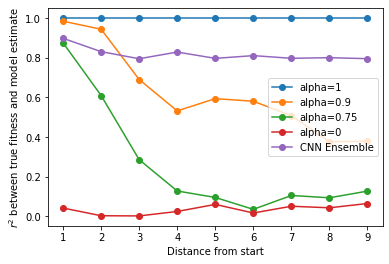

In [5]:
for name, corr in corrs.items():
    plt.plot(range(1, 11), corr, 'o-', label=name)
plt.ylabel("$r^2$ between true fitness and model estimate")
plt.xlabel("Distance from start")
plt.legend()
plt.show()

## Figure 2B

We run Adalead, CbAS, DbAS over 

In [11]:
problem = flexs.landscapes.rna.registry()['L14_RNA1+2']
wt = problem['starts'][2]
landscape = flexs.landscapes.RNABinding(**problem['params'])

In [63]:
for i in range(5):
    print(f'\nBeginning run {i}')
    random = baselines.explorers.Random(
        flexs.LandscapeAsModel(landscape),
        rounds=10,
        mu=1,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/random/run{i}.csv'
    )
    random.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395
round: 1, top: 0.4675010852858295
round: 2, top: 0.5038493641670606
round: 3, top: 0.5913390150604345
round: 4, top: 0.5913390150604345
round: 5, top: 0.5913390150604345
round: 6, top: 0.5913390150604345
round: 7, top: 0.5913390150604345
round: 8, top: 0.61701335703094
round: 9, top: 0.61701335703094
round: 10, top: 0.61701335703094

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.5415706951216871
round: 2, top: 0.6439571721972801
round: 3, top: 0.6439571721972801
round: 4, top: 0.6439571721972801
round: 5, top: 0.6439571721972801
round: 6, top: 0.6843728949467904
round: 7, top: 0.6843728949467904
round: 8, top: 0.6843728949467904
round: 9, top: 0.6843728949467904
round: 10, top: 0.6843728949467904

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.5429437985863315
round: 2, top: 0.5429437985863315
round: 3, top: 0.585794812257223
round: 4, top: 0.585794812257223
round: 5, top: 0.6048627377780094


In [18]:
for i in range(5):
    print(f'\nBeginning run {i}')
    adalead = baselines.explorers.Adalead(
        flexs.LandscapeAsModel(landscape),
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/adalead/run{i}.csv'
    )
    adalead.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395
round: 1, top: 0.762509948650927
round: 2, top: 0.9996155015582209
round: 3, top: 0.9996155015582209
round: 4, top: 0.9996155015582209
round: 5, top: 0.9996155015582209
round: 6, top: 1.0023099447443538
round: 7, top: 1.0319481003143287
round: 8, top: 1.0319481003143287
round: 9, top: 1.0319481003143287
round: 10, top: 1.0319481003143287

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.8406470537463127
round: 2, top: 0.9996155015582209
round: 3, top: 1.0319481003143287
round: 4, top: 1.0319481003143287
round: 5, top: 1.0319481003143287
round: 6, top: 1.0319481003143287
round: 7, top: 1.0319481003143287
round: 8, top: 1.0319481003143287
round: 9, top: 1.0319481003143287
round: 10, top: 1.0319481003143287

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.6835438557611888
round: 2, top: 0.8379526619514288
round: 3, top: 0.9915323775648184
round: 4, top: 1.0319481003143287
round: 5, top: 1.0319481003

In [23]:
for i in range(5):
    print(f'\nBeginning run {i}')
    vae = baselines.explorers.VAE(len(wt), alphabet=s_utils.RNAA, epochs=20, verbose=False)
    cbas = baselines.explorers.CbAS(
        flexs.LandscapeAsModel(landscape),
        vae,
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/cbas/run{i}.csv'
    )
    cbas.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395
round: 1, top: 0.6709009873636202
round: 2, top: 0.6709009873636202
round: 3, top: 0.7553076789775309
round: 4, top: 0.7553076789775309
round: 5, top: 0.7553076789775309
round: 6, top: 0.7553076789775309
round: 7, top: 0.7553076789775309
round: 8, top: 0.7553076789775309
round: 9, top: 0.7553076789775309
round: 10, top: 0.7553076789775309

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.6010543433919838
round: 2, top: 0.6808494901560751
round: 3, top: 0.6808494901560751
round: 4, top: 0.6808494901560751
round: 5, top: 0.6808494901560751
round: 6, top: 0.6808494901560751
round: 7, top: 0.6808494901560751
round: 8, top: 0.6808494901560751
round: 9, top: 0.7045548744499677
round: 10, top: 0.7045548744499677

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.6360553823288997
round: 2, top: 0.7079487497373381
round: 3, top: 0.7079487497373381
round: 4, top: 0.7079487497373381
round: 5, top: 0.707948749

In [44]:
for i in range(5):
    print(f'\nBeginning run {i}')
    vae = baselines.explorers.VAE(len(wt), alphabet=s_utils.RNAA, epochs=20, verbose=False)
    dbas = baselines.explorers.CbAS(
        flexs.LandscapeAsModel(landscape),
        vae,
        algo='dbas',
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/dbas/run{i}.csv'
    )
    dbas.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.7301774012860682
round: 2, top: 0.7301774012860682
round: 3, top: 0.7301774012860682
round: 4, top: 0.7301774012860682
round: 5, top: 0.7301774012860682
round: 6, top: 0.7894537638172672
round: 7, top: 0.7894537638172672
round: 8, top: 0.7894537638172672
round: 9, top: 0.7894537638172672
round: 10, top: 0.7894537638172672

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.6048109226436046
round: 2, top: 0.6116246248324213
round: 3, top: 0.6116246248324213
round: 4, top: 0.6425840687326358
round: 5, top: 0.6425840687326358
round: 6, top: 0.6425840687326358
round: 7, top: 0.6425840687326358
round: 8, top: 0.7005391943248442
round: 9, top: 0.7005391943248442
round: 10, top: 0.7005391943248442

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.6864973222398048
round: 2, top: 0.6864973222398048
round: 3, top: 0.6864973222398048
round: 4, top: 0.6864973222398048
round: 5, top: 0.6864973222398048
round: 6, top: 0.6864973222398048
round: 7, 

In [47]:
for i in range(5):
    print(f'\nBeginning run {i}')
    cmaes = baselines.explorers.CMAES(
        flexs.LandscapeAsModel(landscape),
        population_size=10,
        max_iter=400,
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/cmaes/run{i}.csv'
    )
    cmaes.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395
round: 1, top: 0.3650627930758317
round: 2, top: 0.4337954344563264
round: 3, top: 0.45915888660869475
round: 4, top: 0.4894188470164226
round: 5, top: 0.4894188470164226
round: 6, top: 0.4894188470164226
round: 7, top: 0.6870672867416742
round: 8, top: 0.7571212164524084
round: 9, top: 0.7732875158304624
round: 10, top: 0.7732875158304624

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.27879076194752395
round: 2, top: 0.30715948261802806
round: 3, top: 0.38260217022290544
round: 4, top: 0.4903774565838906
round: 5, top: 0.61701335703094
round: 6, top: 0.7247886176963005
round: 7, top: 0.7894537638172672
round: 8, top: 0.8756739929060553
round: 9, top: 0.9268672828351008
round: 10, top: 0.9268672828351008

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.38117726471874147
round: 2, top: 0.385400191792453
round: 3, top: 0.43928782212513334
round: 4, top: 0.43928782212513334
round: 5, top: 0.46812

In [54]:
for i in range(5):
    print(f'\nBeginning run {i}')
    ppo = baselines.explorers.PPO(
        flexs.LandscapeAsModel(landscape),
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/ppo/run{i}.csv'
    )
    ppo.run(landscape)


Beginning run 0
round: 0, top: 0.27879076194752395
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
round: 1, top: 0.6358222330694729
round: 2, top: 0.8912184874463563
round: 3, top: 0.8912184874463563
round: 4, top: 0.9187322923160446
round: 5, top: 0.9187322923160446
round: 6, top: 0.9187322923160446
round: 7, top: 0.9187322923160446
round: 8, top: 0.9726716863918807
round: 9, top: 0.9726716863918807
round: 10, top: 0.9726716863918807

Beginning run 1
round: 0, top: 0.27879076194752395
round: 1, top: 0.7730284002682084
round: 2, top: 0.9430335308219058
round: 3, top: 0.9430335308219058
round: 4, top: 0.9430335308219058
round: 5, top: 0.9430335308219058
round: 6, top: 0.9430335308219058
round: 7, top: 0.9430335308219058
round: 8, top: 0.9430335308219058
round: 9, top: 1.0319481003143287
round: 10, top: 1.0319481003143287

Beginning run 2
round: 0, top: 0.27879076194752395
round: 1, top: 0.8622020853228852
round: 2, top: 0.9484223144116734
roun

In [59]:
for i in range(5):
    print(f'\nBeginning run {i}')
    dyna_ppo = baselines.explorers.DynaPPO(
        rounds=10,
        num_model_rounds=1,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2b/dyna_ppo/run{i}.csv'
    )
    dyna_ppo.run(landscape)


Beginning run 0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


round: 0, top: 0.27879076194752395
round: 1, top: 0.6186455351793165
round: 2, top: 0.6927928488713867
round: 3, top: 0.6927928488713867
round: 4, top: 0.7490380410677568
round: 5, top: 0.7490380410677568
round: 6, top: 0.7490380410677568
round: 7, top: 0.7490380410677568
round: 8, top: 0.7490380410677568
round: 9, top: 0.7490380410677568
round: 10, top: 0.7490380410677568

Beginning run 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


round: 0, top: 0.27879076194752395
round: 1, top: 0.7409549170743546
round: 2, top: 0.7490380410677568
round: 3, top: 0.7490380410677568
round: 4, top: 0.7490380410677568
round: 5, top: 0.7490380410677568
round: 6, top: 0.7490380410677568
round: 7, top: 0.7490380410677568
round: 8, top: 0.7490380410677568
round: 9, top: 0.7490380410677568
round: 10, top: 0.7519138183789119

Beginning run 2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


round: 0, top: 0.27879076194752395
round: 1, top: 0.4406868405013557
round: 2, top: 0.6789841627482718
round: 3, top: 0.6789841627482718
round: 4, top: 0.7680541766556175
round: 5, top: 0.7680541766556175
round: 6, top: 0.7680541766556175
round: 7, top: 0.7680541766556175
round: 8, top: 0.7680541766556175
round: 9, top: 0.7680541766556175
round: 10, top: 0.7680541766556175

Beginning run 3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


round: 0, top: 0.27879076194752395
round: 1, top: 0.6439571721972801
round: 2, top: 0.6439571721972801
round: 3, top: 0.6439571721972801
round: 4, top: 0.6439571721972801
round: 5, top: 0.677999652957977
round: 6, top: 0.677999652957977
round: 7, top: 0.7192962300274937
round: 8, top: 0.7192962300274937
round: 9, top: 0.7192962300274937
round: 10, top: 0.7192962300274937

Beginning run 4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


round: 0, top: 0.27879076194752395
round: 1, top: 0.5968314289190118
round: 2, top: 0.600847057652886
round: 3, top: 0.6620924544534257
round: 4, top: 0.6620924544534257
round: 5, top: 0.6620924544534257
round: 6, top: 0.6789841627482718
round: 7, top: 0.6789841627482718
round: 8, top: 0.7087000483642295
round: 9, top: 0.7087000483642295
round: 10, top: 0.7247886176963005


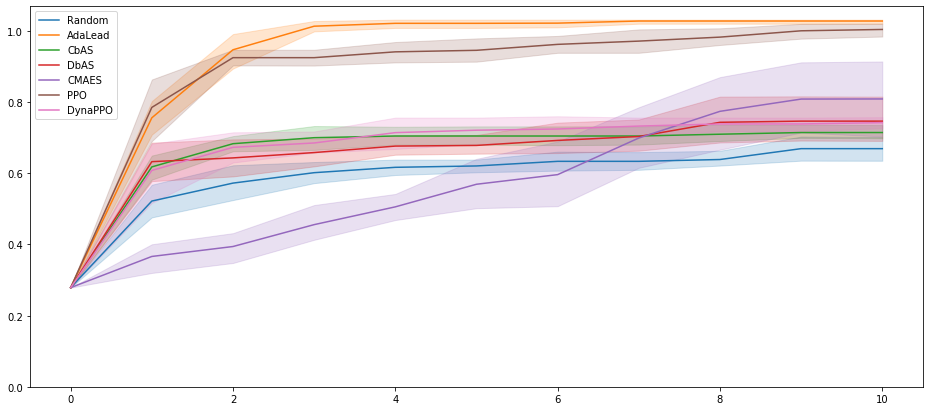

In [70]:
import glob
import pandas as pd

def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    rounds = []
    scores = []
    for fname in glob.glob(f'{run_dir}/*'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        rounds.extend(range(len(max_per_round)))
    
    return rounds, scores

plt.figure(figsize=(16, 7))
sns.lineplot(*compute_scores('plots/2b/random'), label="Random")
sns.lineplot(*compute_scores('plots/2b/adalead'), label="AdaLead")
sns.lineplot(*compute_scores('plots/2b/cbas'), label="CbAS")
sns.lineplot(*compute_scores('plots/2b/dbas'), label="DbAS")
sns.lineplot(*compute_scores('plots/2b/cmaes'), label="CMAES")
sns.lineplot(*compute_scores('plots/2b/ppo'), label="PPO")
sns.lineplot(*compute_scores('plots/2b/dyna_ppo'), label="DynaPPO")
plt.ylim(0)
plt.show()

## Figure 2D

In [ ]:
def make_adalead(model, ss):
    return baselines.explorers.Adalead(
        model,
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.RNAA,
        log_file=f'plots/2d/adalead/signal_strength={ss}'
    )
flexs.evaluate.robustness(landscape, make_explorer)

## Comparing our implementation to that in the DyNAPPO paper

In [82]:
problem = flexs.landscapes.tf_binding.registry()['SIX6_REF_R1']
wt = 'AAAAAAAA'
landscape = flexs.landscapes.TFBinding(**problem['params'])

In [86]:
for i in range(5):
    print(f'\nBeginning run {i}')
    random = baselines.explorers.Random(
        flexs.LandscapeAsModel(landscape),
        rounds=10,
        mu=1,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.DNAA,
    )
    random.run(landscape)


Beginning run 0
round: 0, top: 0.5247495155238527
round: 1, top: 0.871881829052076
round: 2, top: 0.8994454294314106
round: 3, top: 0.9246072650806088
round: 4, top: 0.9246072650806088
round: 5, top: 0.9246072650806088
round: 6, top: 0.9246072650806088
round: 7, top: 0.9732094998556879
round: 8, top: 0.9794149177421351
round: 9, top: 0.9794149177421351
round: 10, top: 0.9794149177421351

Beginning run 1
round: 0, top: 0.5247495155238527
round: 1, top: 0.8724693852306932
round: 2, top: 0.9030738465344494
round: 3, top: 0.9771986970684039
round: 4, top: 0.9771986970684039
round: 5, top: 0.9771986970684039
round: 6, top: 0.9771986970684039
round: 7, top: 0.9771986970684039
round: 8, top: 0.9771986970684039
round: 9, top: 0.9771986970684039
round: 10, top: 0.9771986970684039

Beginning run 2
round: 0, top: 0.5247495155238527
round: 1, top: 0.9565414587886034
round: 2, top: 0.961973776440028
round: 3, top: 0.961973776440028
round: 4, top: 0.961973776440028
round: 5, top: 0.9692615346555066

In [96]:
for i in range(5):
    print(f'\nBeginning run {i}')
    dyna_ppo = baselines.explorers.DynaPPO(
        rounds=10,
        num_model_rounds=1,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.DNAA,
        log_file=f'plots/dyna_ppo_six6/run{i}.csv'
    )
    dyna_ppo.run(landscape)


Beginning run 0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 0, top: 0.5247495155238527


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is consta

round: 1, top: 0.8964767245289242


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 2, top: 0.9114336370758258


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 3, top: 0.9616026883272173


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 4, top: 0.9694780027213128


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 5, top: 0.982589782707294


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 6, top: 0.982589782707294


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 7, top: 0.982589782707294


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 8, top: 0.9831051828639755


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 9, top: 0.9831051828639755


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 10, top: 0.9831051828639755

Beginning run 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An in

round: 0, top: 0.5247495155238527
round: 1, top: 0.8904362346926153


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 2, top: 0.9719106914608502


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 3, top: 0.9719106914608502


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 4, top: 0.9741062961283141


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 5, top: 0.9741062961283141


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 6, top: 0.9741062961283141


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 7, top: 0.9741062961283141


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 8, top: 0.9942172102420319


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 9, top: 0.9942172102420319


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 10, top: 0.9942172102420319

Beginning run 2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An in

round: 0, top: 0.5247495155238527
round: 1, top: 0.9302148187853049


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 2, top: 0.9302148187853049


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 3, top: 0.9657155815775369


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 4, top: 0.9692615346555066


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 5, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 6, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 7, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 8, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 9, top: 0.9935059580258113


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 10, top: 0.9935059580258113

Beginning run 3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An in

round: 0, top: 0.5247495155238527
round: 1, top: 0.9761988207644415


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 2, top: 0.9761988207644415


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 3, top: 0.9761988207644415


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 4, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 5, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 6, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 7, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 8, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 9, top: 0.989691996866367


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 10, top: 0.989691996866367

Beginning run 4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An in

round: 0, top: 0.5247495155238527
round: 1, top: 0.8862305694140932


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 2, top: 0.8862305694140932


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 3, top: 0.926421473632128


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 4, top: 0.926421473632128


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 5, top: 0.9794561497546695


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 6, top: 0.9794561497546695


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 7, top: 0.9794561497546695


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 8, top: 0.9795592297860058


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 9, top: 0.9795592297860058


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


round: 10, top: 0.9795592297860058


In [98]:
for i in range(5):
    print(f'\nBeginning run {i}')
    mlp = baselines.models.MLP(len(wt), hidden_size=100, alphabet=s_utils.DNAA, loss='MSE')
    vae = baselines.explorers.VAE(len(wt), alphabet=s_utils.DNAA, epochs=10, verbose=False)
    cbas = baselines.explorers.CbAS(
        mlp,
        vae,
        rounds=10,
        starting_sequence=wt,
        sequences_batch_size=100,
        model_queries_per_batch=1000,
        alphabet=s_utils.DNAA,
        log_file=f'plots/six6_dyna_ppo_paper/cbas'
    )
    cbas.run(landscape)


Beginning run 0
round: 0, top: 0.5247495155238527


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.974724776316332
round: 2, top: 0.974724776316332
round: 3, top: 0.9847338473590895


KeyboardInterrupt: 

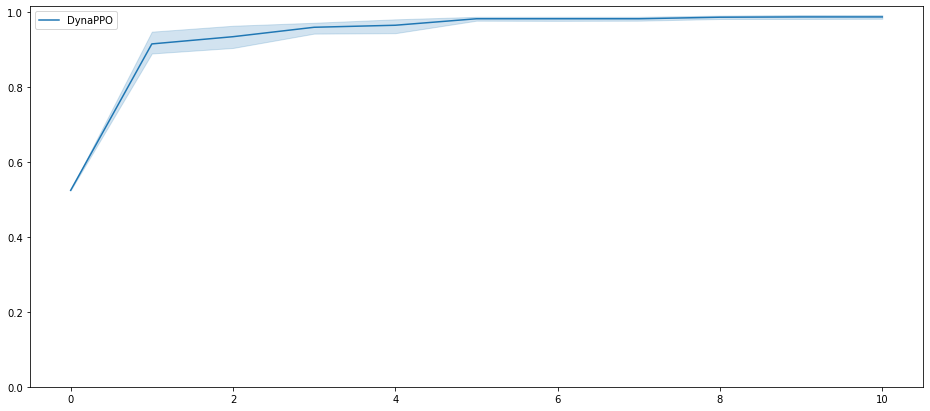

In [97]:
plt.figure(figsize=(16, 7))
sns.lineplot(*compute_scores('plots/dyna_ppo_six6'), label="DynaPPO")
plt.ylim(0)
plt.show()